<a href="https://colab.research.google.com/github/iMuhammadAbdullahAwan/Computer_Vision/blob/main/Quiz/Dynamic_Slip_Cropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q opencv-python matplotlib


Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/util

In [ ]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"

# Download SAM weights (Colab-friendly)
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Load model
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)


Saving slips.jpg to slips (1).jpg


(np.float64(-0.5), np.float64(1129.5), np.float64(1599.5), np.float64(-0.5))

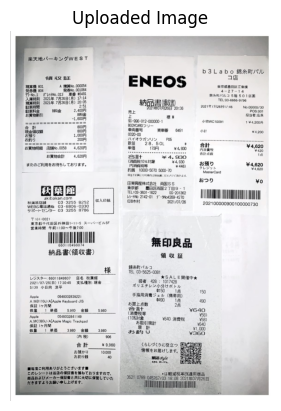

In [ ]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt

uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Uploaded Image")
plt.axis("off")


In [7]:
# Generate masks (requires SAM to be initialized above)
masks = mask_generator.generate(image_rgb)
print("Total segments found:", len(masks))


Total segments found: 95


20 tiles saved in cropped_large_tiles (from top 5 regions)


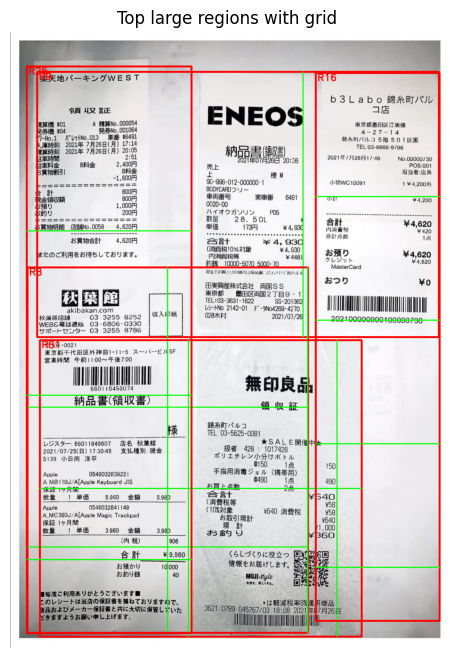

In [13]:
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

os.makedirs('cropped_large_tiles', exist_ok=True)
annot = image_rgb.copy()

# --- Settings ---
MIN_AREA = 12000
MIN_SIDE = 120
TILE_MIN = 150
MAX_TILES = 9
MAX_REGIONS = 5
RECT_THICK = 4
GRID_COLOR = (0,255,0)
RECT_COLOR = (255,0,0)
SKIP_COLOR = (200,200,200)

# Build candidate list (idx, area, bbox)
candidates = []
for idx, m in enumerate(masks, start=1):
    x, y, w, h = map(int, m['bbox'])
    area = w * h
    if area >= MIN_AREA and w >= MIN_SIDE and h >= MIN_SIDE:
        candidates.append((idx, area, (x, y, w, h)))

# Sort by area and pick top-N
candidates.sort(key=lambda x: x[1], reverse=True)
selected = candidates[:MAX_REGIONS]
selected_idx = set([c[0] for c in selected])

tile_index = 1
annot_display = annot.copy()

# Process selected regions
for idx, area, bbox in selected:
    x, y, w, h = bbox
    cv2.rectangle(annot_display, (x, y), (x+w, y+h), RECT_COLOR, RECT_THICK)
    cv2.putText(annot_display, f'R{idx}', (x+5, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, RECT_COLOR, 2)

    min_side = min(w, h)
    tile_size = max(TILE_MIN, int(min_side // 2))
    def total_tiles_for(tile_s):
        nx = math.ceil(w / tile_s)
        ny = math.ceil(h / tile_s)
        return nx * ny
    while tile_size < min_side and total_tiles_for(tile_size) > MAX_TILES:
        tile_size = min_side if total_tiles_for(min_side) <= MAX_TILES else int(tile_size * 1.25) + 1
    if tile_size < TILE_MIN or tile_size > min_side:
        continue

    nx = math.ceil(w / tile_size)
    ny = math.ceil(h / tile_size)

    # Draw grid lines
    for ix in range(1, nx):
        gx = x + ix * tile_size
        cv2.line(annot_display, (gx, y), (gx, y+h), GRID_COLOR, 2)
    for iy in range(1, ny):
        gy = y + iy * tile_size
        cv2.line(annot_display, (x, gy), (x+w, gy), GRID_COLOR, 2)

    # Save tiles **masked**
    m = masks[idx-1]
    mask_seg = m['segmentation']
    for iy in range(ny):
        for ix in range(nx):
            sx = x + ix * tile_size
            sy = y + iy * tile_size
            ex = min(x + w, sx + tile_size)
            ey = min(y + h, sy + tile_size)
            tw = ex - sx
            th = ey - sy
            if tw < TILE_MIN or th < TILE_MIN:
                continue

            crop_img = image_rgb[sy:ey, sx:ex].copy()
            crop_mask = mask_seg[sy:ey, sx:ex]
            crop_img[~crop_mask] = 0  # apply mask

            fname = f'cropped_large_tiles/region_{idx}_tile_{tile_index}.jpg'
            cv2.imwrite(fname, cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR))
            tile_index += 1

print(f'{tile_index-1} tiles saved in cropped_large_tiles (from top {len(selected)} regions)')

# Show annotated image
plt.figure(figsize=(12,8))
plt.imshow(annot_display)
plt.title('Top large regions with grid')
plt.axis('off')
plt.show()


In [14]:
os.makedirs("cropped_slips", exist_ok=True)
# Remove old crops
for f in os.listdir("cropped_slips"):
    p = os.path.join("cropped_slips", f)
    if os.path.isfile(p):
        os.remove(p)

index = 1
to_process = selected if 'selected' in globals() else []

for idx, area, bbox in to_process:
    m = masks[idx-1]
    mask_seg = m['segmentation']
    x, y, w, h = map(int, bbox)

    crop_img = image_rgb[y:y+h, x:x+w].copy()
    crop_mask = mask_seg[y:y+h, x:x+w]
    crop_img[~crop_mask] = 0

    fname = f"cropped_slips/slip_{index}_r{idx}.jpg"
    cv2.imwrite(fname, cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR))
    index += 1

print(f"{index-1} mask-clean slips saved in cropped_slips!")


5 mask-clean slips saved in cropped_slips!


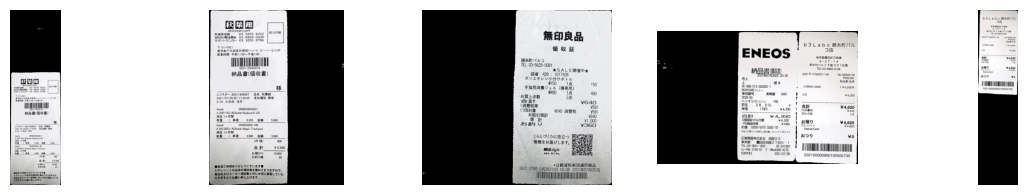

In [16]:
import matplotlib.pyplot as plt
import glob

files = glob.glob("cropped_slips/*.jpg")
plt.figure(figsize=(15,5))
for i, f in enumerate(files[:10], start=1):  # show first 10 slips
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [17]:
# Create a zip of the cropped images and include this notebook if available, then download
import os
import shutil
import zipfile
from google.colab import files

zip_name = 'cropped_slips'
zip_path = zip_name + '.zip'
# remove old zip if present
if os.path.exists(zip_path):
    os.remove(zip_path)
# create zip from folder
if os.path.isdir('cropped_slips'):
    shutil.make_archive(zip_name, 'zip', root_dir='.', base_dir='cropped_slips')
else:
    print('No cropped_slips folder found to zip')
# include notebook file if present in working dir
nb_name = 'Dynamic_Slip_Cropping.ipynb'
if os.path.exists(nb_name):
    with zipfile.ZipFile(zip_path, 'a') as zf:
        zf.write(nb_name)
        print(f'Included notebook: {nb_name} in {zip_path}')
else:
    print('Notebook file not found in working directory; zip contains only images')

# download the zip
if os.path.exists(zip_path):
    files.download(zip_path)
else:
    print('Nothing to download')


Notebook file not found in working directory; zip contains only images


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>